In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
enc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 512),
    nn.LeakyReLU(0.2, True),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2, True),
    nn.Linear(256, 128),
    nn.LeakyReLU(0.2, True),
    nn.Linear(128, 100),
    nn.Tanh(),
).to(device)
dec = nn.Sequential(
    nn.Linear(100, 128),
    nn.LeakyReLU(0.2, True),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2, True),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2, True),
    nn.Linear(512, 28 * 28),
    nn.Unflatten(1, (1, 28, 28)),
    nn.Tanh(),
).to(device)
ss = lambda x, k: x * torch.sign(k)

In [3]:
tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
ds = MNIST(root="/mnt/external/pytorch_datasets/", transform=tf)
dl = DataLoader(ds, 128, True)

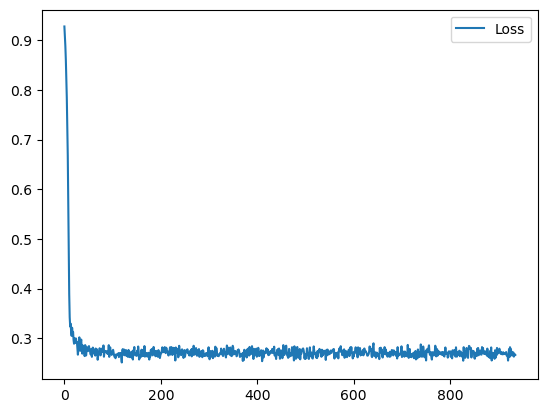

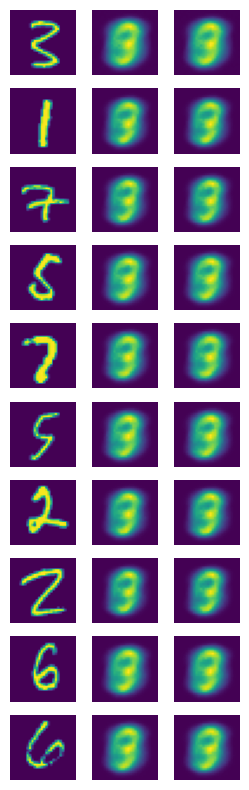

In [4]:
criterion = nn.MSELoss()
optim = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()))

losses = []
samples = next(iter(dl))[0].to(device)

for epoch in range(2):
    for batch in dl:
        batch = batch[0].to(device)
        if batch.shape[0] != 128:
            break
        optim.zero_grad()
        k = torch.rand(128, 100, device=device) * 2 - 1
        loss = criterion(dec(ss(enc(dec(ss(enc(batch), k))), k)), batch)
        losses.append(loss.item())
        loss.backward()
        optim.step()

plt.plot(losses)
plt.legend(["Loss"])
plt.show()
k = torch.rand(128, 100, device=device) * 2 - 1
with torch.no_grad():
    encr = dec(ss(enc(samples), k))
    decr = dec(ss(enc(encr), k))
plt.figure(figsize=(3, 10))
for i in range(10):
    plt.subplot(10, 3, 3*i+1)
    plt.axis("off")
    plt.imshow(samples[i].cpu().squeeze())
    plt.subplot(10, 3, 3*i+2)
    plt.axis("off")
    plt.imshow(encr[i].cpu().squeeze())
    plt.subplot(10, 3, 3*i+3)
    plt.axis("off")
    plt.imshow(decr[i].cpu().squeeze())
plt.show()
